In [19]:
from Pyfhel import Pyfhel
from PolyApproxFunctions import generate_plots, plot_poly, step_function, poly_approx, display_poly
import numpy as np
from DatasetVisualizationFunctions import plot_histograms, dataset_preprocessing
import pandas as pd
from sklearn import datasets
import time
from TrainingFunctions import training_preprocess, initialization, training_function
from ComparisonFunctions import total_comparison
import pickle

# Polynomial Approximation of the Step Function

The first step in implementing Tree-Based Machine Learning models that support prediction on encrypted data is obtaining a good polynomial approximation of the threshold function: 
$$
f(x) =
\begin{cases}
    0 & \text{if } x < 0 \\
    1 & \text{if } otherwise \\
\end{cases}
$$

This is because it is very hard to evaluate some functions on FHE input, precisely because of the characteristics of the encryption. Therefore, Akavia et al. have proposed a protocol that does not need to evaluate the hard threshold function on encrypted data, but rather it requires the evaluation of a polynomial approximation of such threshold, which is much more FHE friendly.

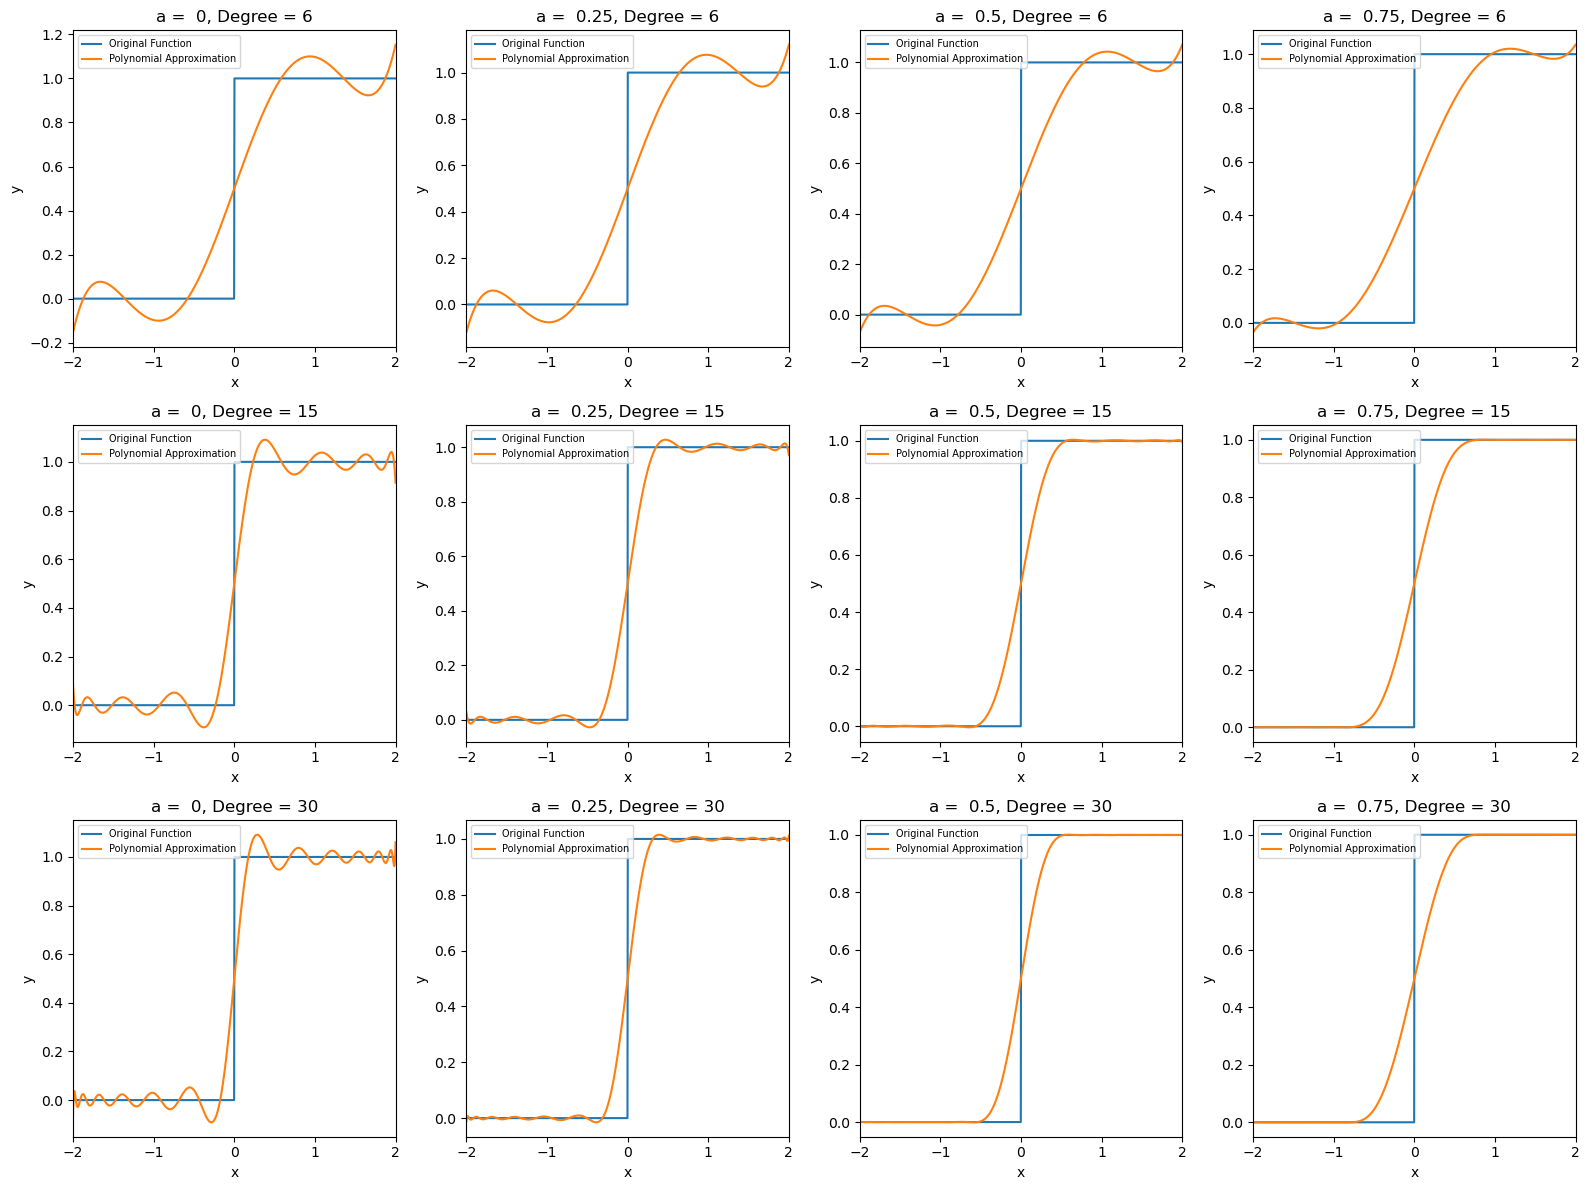

In [3]:
degrees = [6, 15, 30]
windows = [0, 0.25, 0.5, 0.75]

list_of_dicts = [
    {"degree": degree, "interval": window}
    for degree in degrees
    for window in windows
]

generate_plots(plot_poly, step_function, list_of_dicts)

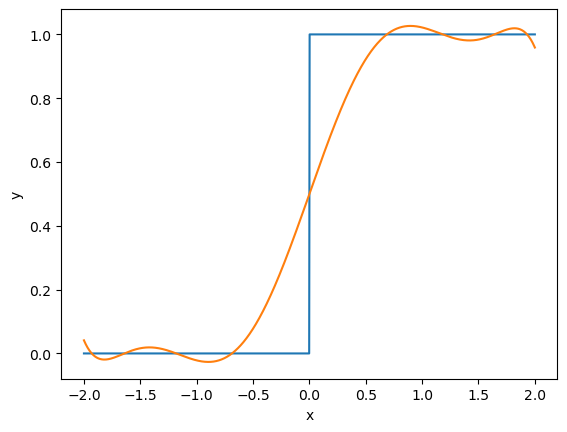

In [4]:
phi = poly_approx(step_function, 7, 2, 0.5)
display_poly(step_function, phi, 2)

# Data Exploration and Cleaning

## Cancer Dataset

In [5]:
cancer = datasets.load_breast_cancer()
feature_names = cancer.feature_names
cancer.feature_names
X = pd.DataFrame(cancer['data'], columns = cancer.feature_names)
y = pd.DataFrame(cancer['target'], columns = ['cancer type'])
cancer = pd.concat([X, y], axis = 1)
cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,cancer type
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


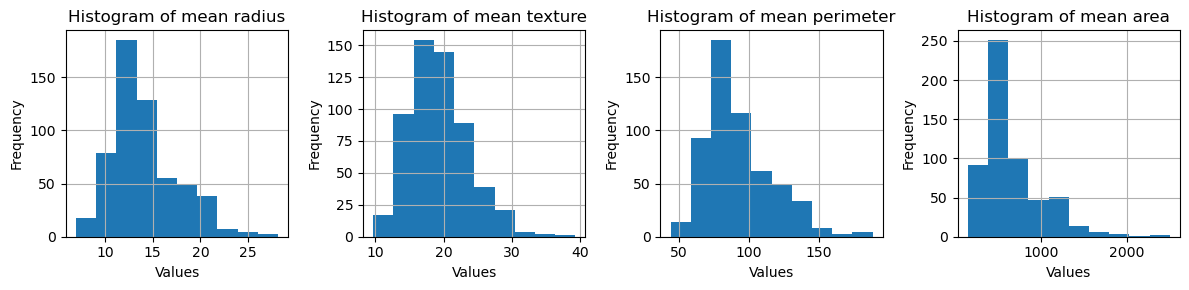

In [6]:
plot_histograms(cancer[:-1], 4)

As we can see from the above histograms, the data needs to be normalized and rescaled.

In [7]:
cancer_X_train, cancer_X_test, cancer_y_train, cancer_y_test = dataset_preprocessing(cancer, feature_names,'cancer type', feature_names, 0)

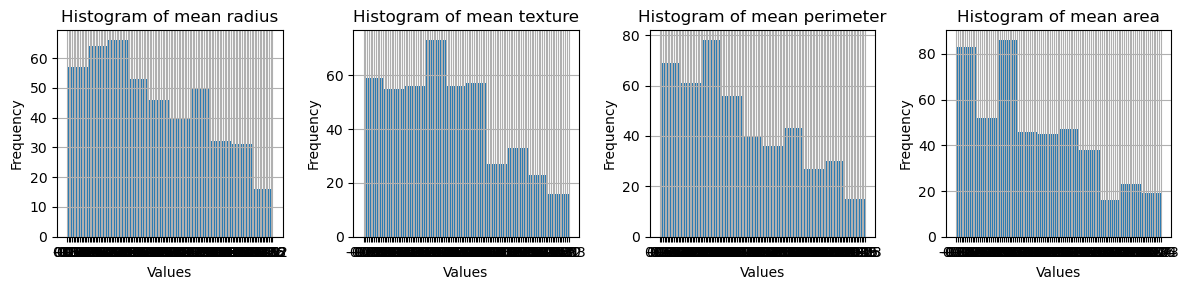

In [8]:
plot_histograms(cancer_X_train, 4)

## Iris Dataset

In [9]:
iris = datasets.load_iris()
feature_names = iris.feature_names
X = pd.DataFrame(iris['data'], columns = feature_names)
y = pd.DataFrame(iris['target'], columns = ['Species Type'])
iris = pd.concat([X, y], axis = 1)
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species Type
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


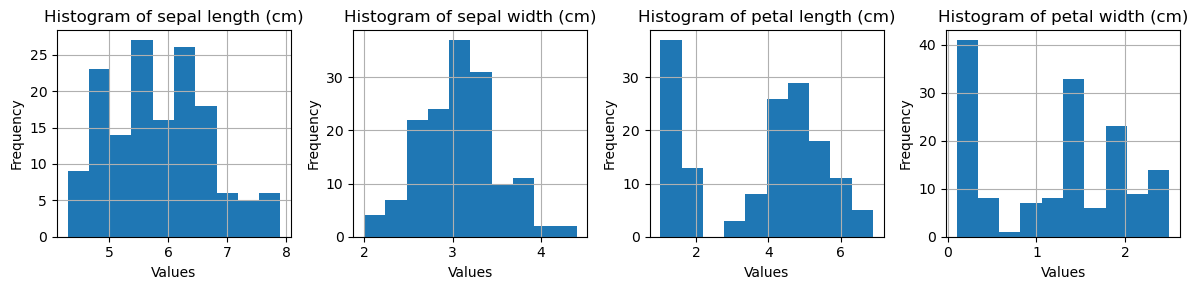

In [10]:
plot_histograms(iris, 4)

In [11]:
iris_X_train, iris_X_test, iris_y_train, iris_y_test = dataset_preprocessing(iris, feature_names,'Species Type', feature_names, 0)

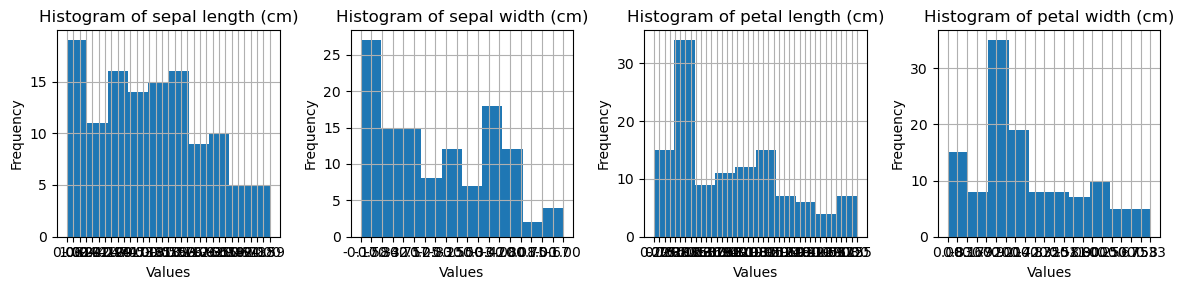

In [12]:
plot_histograms(iris_X_train, 4)

## Credit Card Dataset

In [13]:
credit_card = pd.read_csv('/Users/alessandroardenghi/FHEMachineLearning/creditcard.csv', nrows = 1000)
feature_names = credit_card.columns
X = credit_card[feature_names]
y = credit_card['fraud']
credit_card.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


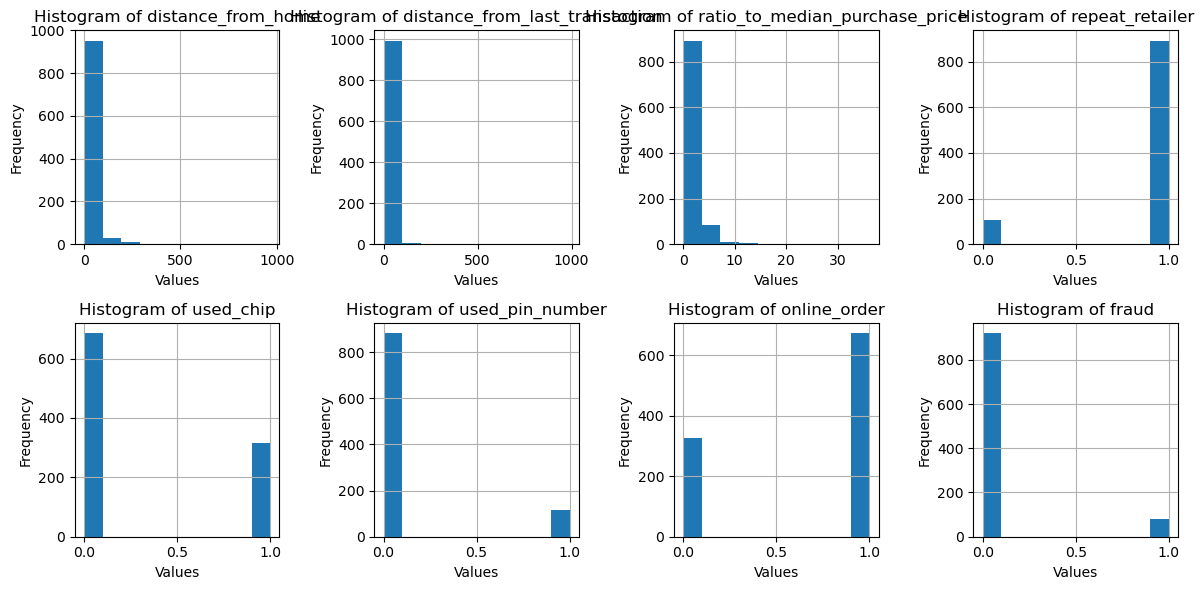

In [14]:
plot_histograms(credit_card, 8)

Again, the data is very unbalanced, so I must preprocess the data accordingly.

In [15]:
cols_to_normalize = feature_names[:3]
cc_X_train, cc_X_test, cc_y_train, cc_y_test = dataset_preprocessing(credit_card, feature_names,'fraud', cols_to_normalize, 1)

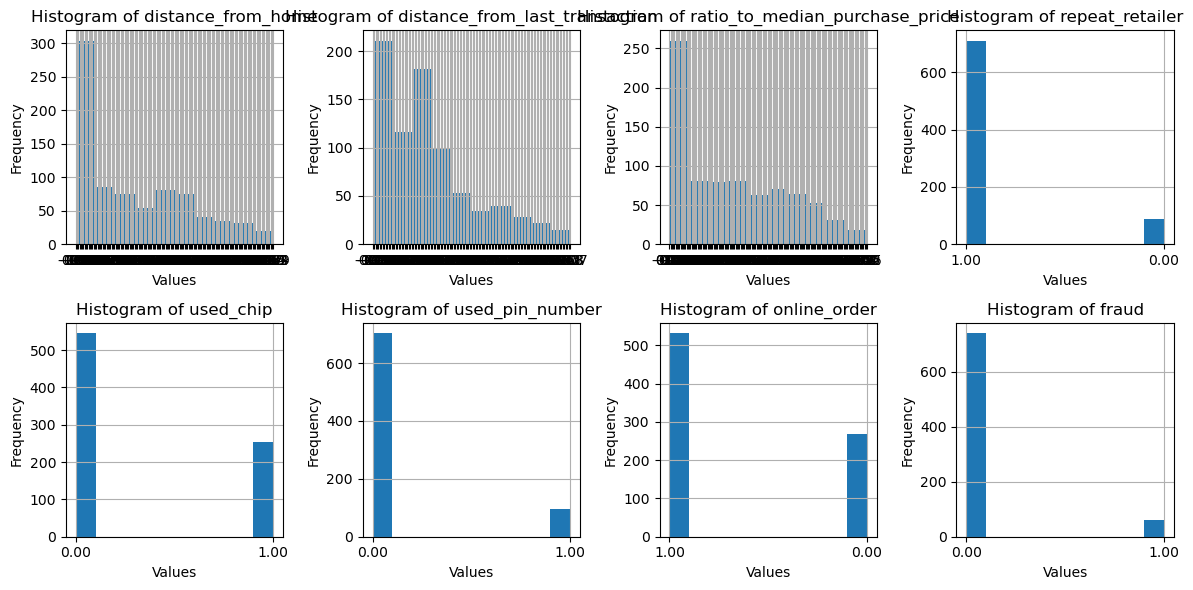

In [16]:
plot_histograms(cc_X_train, 8)

# Training on Cleartext Data

In this first scenario, I assume that the owner of the model also owns (or has access) to some data, on which the training of the model can be performed. 

In [18]:
directory = '/Users/alessandroardenghi/FHEMachineLearning/'

### Trainign on Iris Dataset

In [17]:
n_thresholds = 50
X, y, n_labels, n_features = training_preprocess(iris_X_train, iris_y_train)
S, depth, W, n_thresholds = initialization(len(X), n_thresholds)
degrees = [6, 15]
windows = [0, 0.25, 0.50, 0.75]

In [18]:
iris_times = training_function(X, y, W, n_thresholds, S, degrees, windows, directory + 'trained_models/iris/', 'iris')

Training of Trees of degree 6 completed
Training of Trees of degree 15 completed


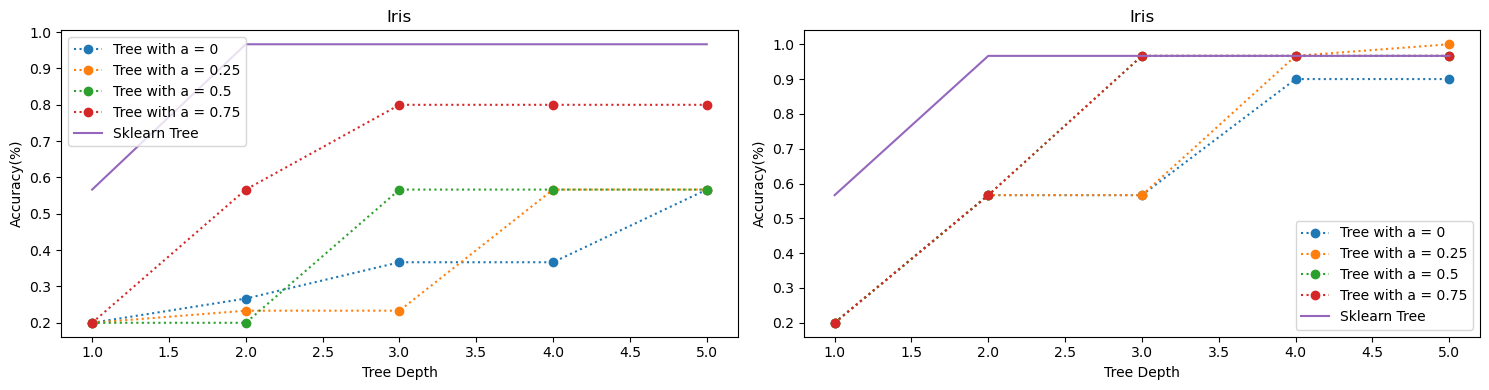

In [19]:
total_comparison(iris_X_train, iris_X_test, iris_y_train, iris_y_test, phi, S,'iris', directory + 'trained_models/iris', degrees, windows)

### Training on Cancer Dataset

In [20]:
n_thresholds = 50
X, y, n_labels, n_features = training_preprocess(cancer_X_train, cancer_y_train)
S, depth, W, n_thresholds = initialization(len(X), n_thresholds)
degrees = [6, 15]
windows = [0, 0.25, 0.50, 0.75]

In [21]:
cancer_times = training_function(X, y, W, n_thresholds, S, degrees, windows, directory + 'trained_models/cancer/', 'cancer')

Training of Trees of degree 6 completed
Training of Trees of degree 15 completed


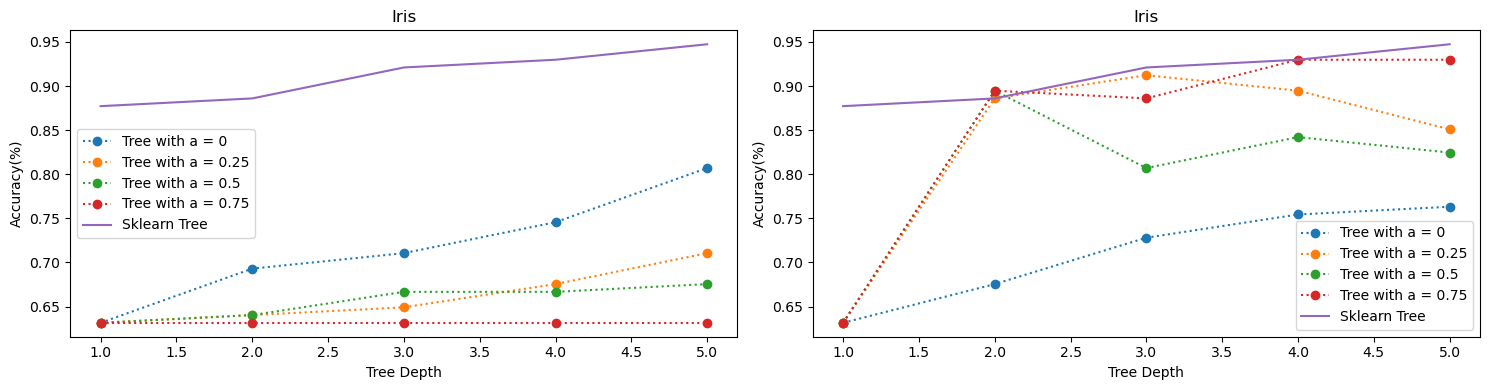

In [22]:
total_comparison(cancer_X_train, cancer_X_test, cancer_y_train, cancer_y_test, phi, S,'cancer', directory + 'trained_models/cancer', degrees, windows)

### Training with Credit Card Dataset

In [23]:
n_thresholds = 50
X, y, n_labels, n_features = training_preprocess(cc_X_train, cc_y_train)
S, depth, W, n_thresholds = initialization(len(X), n_thresholds)
degrees = [6, 15]
windows = [0, 0.25, 0.50, 0.75]

In [24]:
cc_times = training_function(X, y, W, n_thresholds, S, degrees, windows, directory + 'trained_models/creditcard/', 'cc')

Training of Trees of degree 6 completed
Training of Trees of degree 15 completed


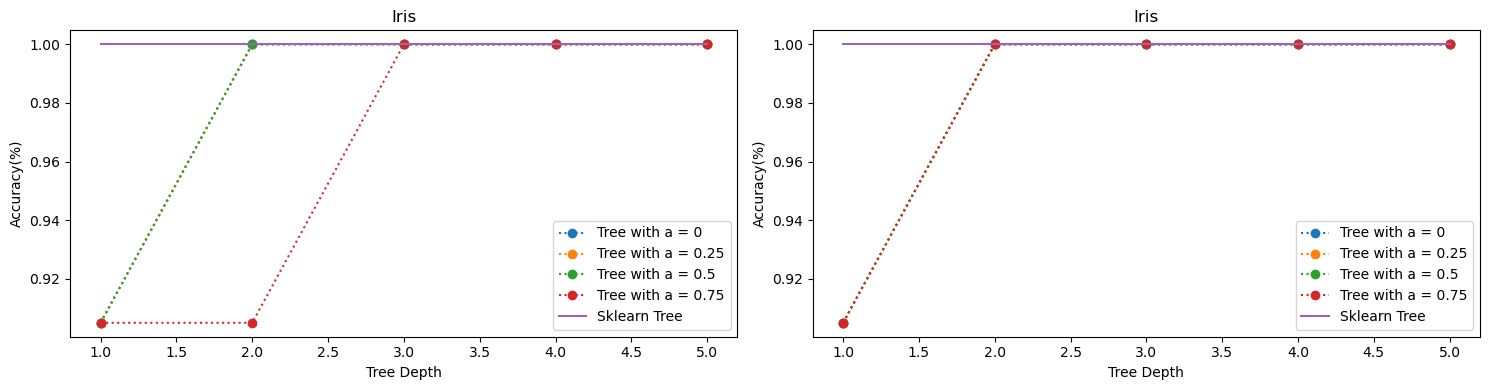

In [25]:
total_comparison(cc_X_train, cc_X_test, cc_y_train, cc_y_test, phi, S,'cc', directory + 'trained_models/creditcard', degrees, windows)

### Best Trees

In [21]:
tree_path = directory + 'trained_models/iris/iris_15_0.25_4.pkl'
decision_tree_model_pkl = open(tree_path, 'rb')
iris_tree = pickle.load(decision_tree_model_pkl)

tree_path = directory + f'trained_models/cancer/cancer_15_0.25_4.pkl'
decision_tree_model_pkl = open(tree_path, 'rb')
cancer_tree = pickle.load(decision_tree_model_pkl)

tree_path = directory + f'trained_models/creditcard/cc_6_0.25_3.pkl'
decision_tree_model_pkl = open(tree_path, 'rb')
cc_tree = pickle.load(decision_tree_model_pkl)